adding import lib

In [40]:
import cv2
import numpy as np
import os
import glob
import mahotas as mt
import matplotlib.pyplot as plt
#from sklearn.svm import LinearSVC

define a extract haralick features function

In [41]:
def extract_haralick_features(image):
        features = mt.features.haralick(image)

        haralick_features_mean = features.mean(axis=0)
        return haralick_features_mean

define a extract Local binary patterns (LBP) function

In [42]:
def extract_LBP(image):
    feat = mt.features.lbp(image=image, points=(2*8), radius=2, ignore_zeros="True")
    feat = np.reshape(cv2.calcHist([np.float32(feat)], [0], None, [256], [0, 256]),(256))
    return feat

Divide the picture as grids (5x4) and calculate features

In [43]:
def features_of_grid(image):
    height = image.shape[0]
    width = image.shape[1]    

    x_step = int(width / 5)
    y_step = int(height / 4)

    x = 0
    y= 0
    
    all_features = []

    for i in range(5):
        if i < 4: 
            w = x_step 
        else:
            w = width - x
        for j in range(4):
            if j < 3: 
                h = y_step 
            else:
                h = height - y
            
            crop_img = image[y:y+h, x:x+w] 
            
            y += h
            if i == 0 and j == 0:
                all_features = extract_haralick_features(crop_img)
            elif i == 0 and j == 1:
                hfc = extract_haralick_features(crop_img)
                all_features = np.stack((all_features, hfc), axis=-1)
            else:
                hfc = []
                hfc.append(extract_haralick_features(crop_img))
                hfc = np.asarray(hfc)
                all_features = np.concatenate((all_features, hfc.T), axis=1)
        x += w
        y= 0
            
    return all_features
    

get haralick features of a probe (20*2*13 - Parameters)

In [44]:
def get_haralick_feature_of_a_probe(image1_path, image2_path):
    image = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
    f = np.column_stack((features_of_grid(gray), features_of_grid(gray2)))
    return f


In [45]:
#stress angle
#stufe
fs = get_haralick_feature_of_a_probe("../Klebeverbindungen_Daten/2D-MakroImages/ProbeE2_1.png", 
                                        "../Klebeverbindungen_Daten/2D-MakroImages/ProbeE2_2.png")
#schräge30
fs60 = get_haralick_feature_of_a_probe("../Klebeverbindungen_Daten/2D-MakroImages/ProbeS2_1.png", 
                                        "../Klebeverbindungen_Daten/2D-MakroImages/ProbeS2_2.png")
#schräge60
fs30  = get_haralick_feature_of_a_probe("../Klebeverbindungen_Daten/2D-MakroImages/ProbeS1_1.png", 
                                        "../Klebeverbindungen_Daten/2D-MakroImages/ProbeS1_2.png")
#runde
fr = get_haralick_feature_of_a_probe("../Klebeverbindungen_Daten/2D-MakroImages/ProbeR3_1.png", 
                                       "../Klebeverbindungen_Daten/2D-MakroImages/ProbeR3_2.png" )

visualize calculated features

<Figure size 432x288 with 0 Axes>

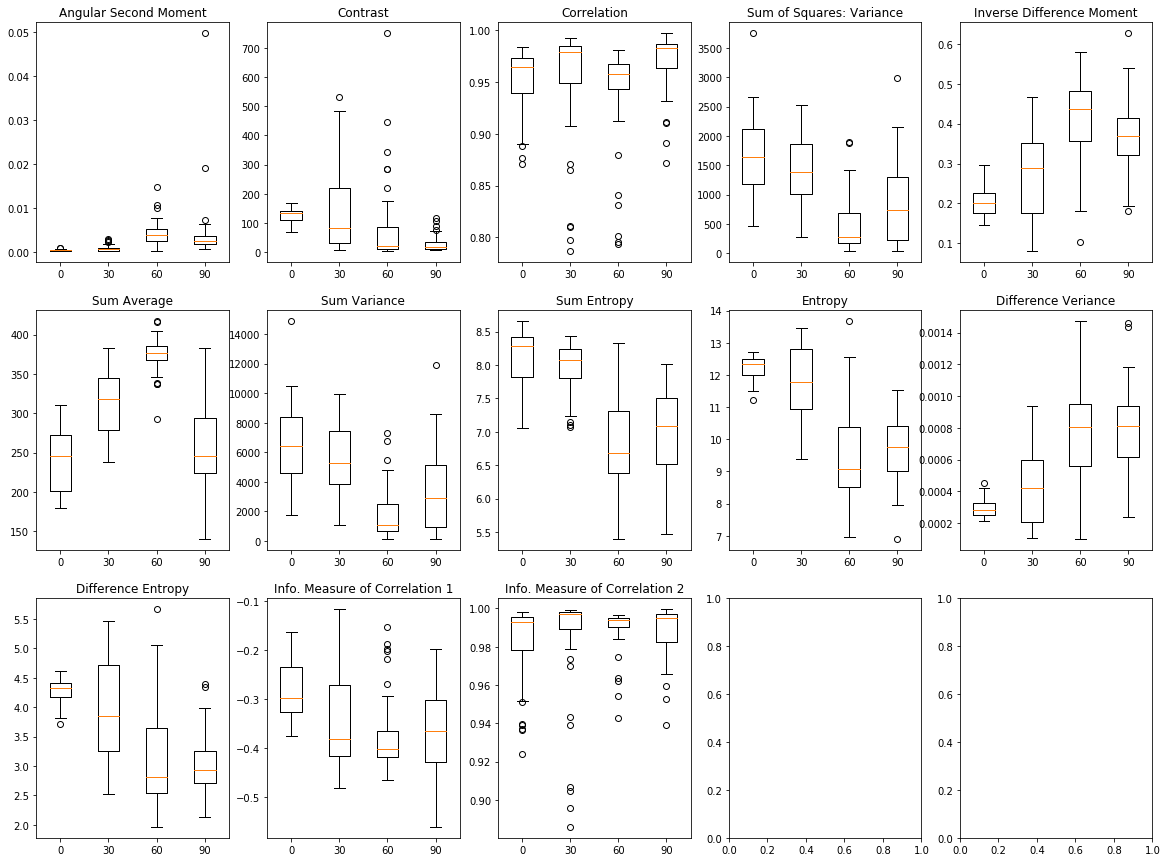

In [46]:
fig = plt.figure()

fig, axs = plt.subplots(3, 5, figsize=(20,15))
langs = ["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
        "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
y_axis = np.arange(40)
for i in range(13):
        x = int(i/5)
        y = int(i % 5)
        axs[x,y].boxplot([fs[i], fs30[i], fs60[i], fr[i]])
        
        axs[x,y].set_title(langs[i])
        axs[x,y].set_xticklabels(["0", "30", "60", "90"])


mean values of haralick features 

<Figure size 432x288 with 0 Axes>

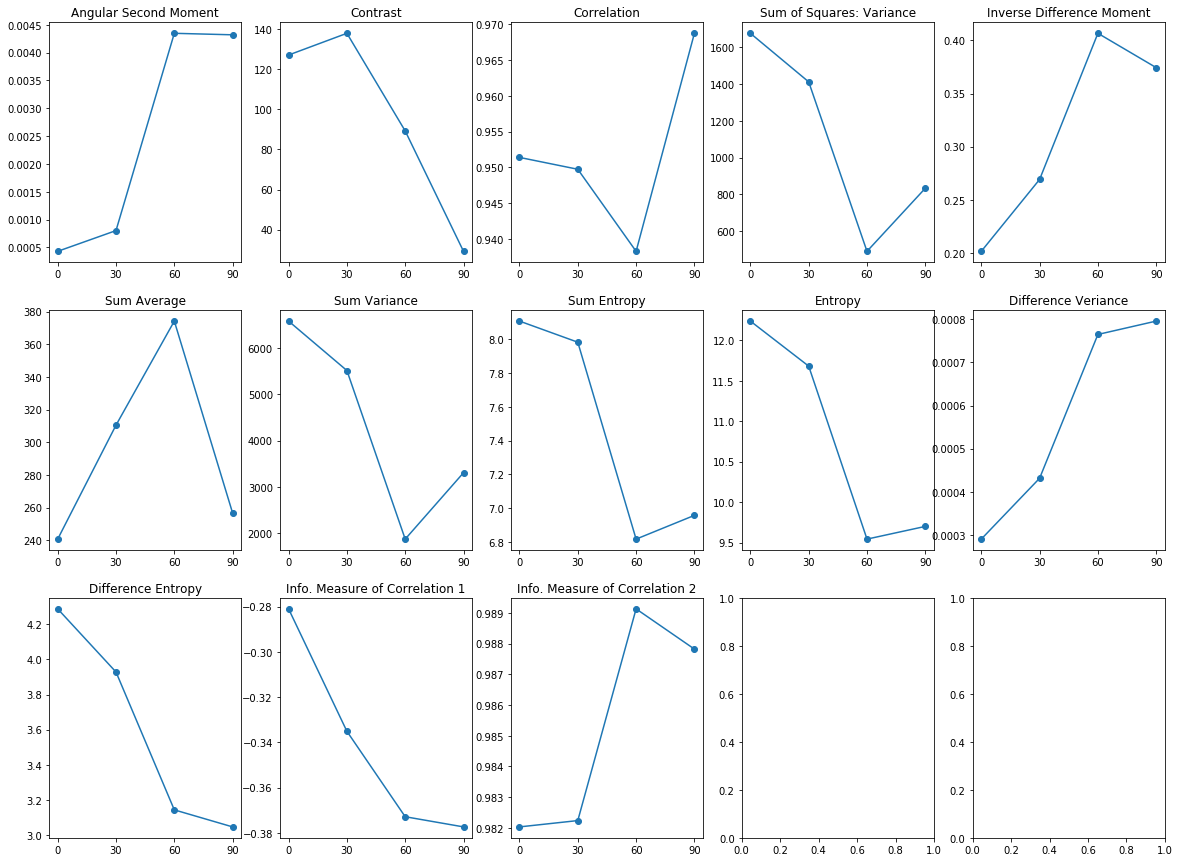

In [47]:
fig = plt.figure()

fig, axs = plt.subplots(3, 5, figsize=(20,15))
langs = ["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
    "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
y_axis = np.arange(40)
for i in range(13):
    x = int(i/5)
    y = int(i % 5)
    axs[x,y].plot([np.mean(fs[i]), np.mean(fs30[i]), np.mean(fs60[i]), np.mean(fr[i])], 'o-')
    
    axs[x,y].set_title(langs[i])
    axs[x,y].set_xticklabels(["0", '0',"30", "60", "90"])


visualize of all features with PCA (principal component analysis)

In [48]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


- grid data

In [49]:
a = np.full(40, "stufe")
dfs = pd.DataFrame(data=fs.T, columns=["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
    "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
)
dfs["target"] = a

a = np.full(40, "schräge30")
dfs30 = pd.DataFrame(data=fs30.T, columns=["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
    "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
)
dfs30["target"] = a

a = np.full(40, "schräge60")
dfs60 = pd.DataFrame(data=fs60.T, columns=["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
    "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
)
dfs60["target"] = a

a = np.full(40, "runde")
dfr = pd.DataFrame(data=fr.T, columns=["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
    "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
)
dfr["target"] = a

frames = [dfs, dfs30, dfs60, dfr]
df = pd.concat(frames)
df


,Angular Second Moment,Contrast,Correlation,Sum of Squares: Variance,Inverse Difference Moment,Sum Average,Sum Variance,Sum Entropy,Entropy,Difference Veriance,Difference Entropy,Info. Measure of Correlation 1,Info. Measure of Correlation 2,target
0,0.000709,135.280061,0.887794,603.013768,0.160379,197.066296,2276.775011,7.296268,11.589545,0.000232,4.462188,-0.174777,0.939468,stufe
1,0.000939,122.410194,0.870985,474.579500,0.172080,185.829447,1775.907807,7.051007,11.234218,0.000256,4.356641,-0.163245,0.924087,stufe
2,0.000602,139.067135,0.938732,1135.060421,0.170275,203.604824,4401.174551,7.656602,11.938202,0.000245,4.432238,-0.218144,0.970588,stufe
3,0.000278,145.191607,0.956736,1678.272016,0.201730,269.512582,6567.896457,8.309939,12.574734,0.000280,4.387695,-0.284137,0.991426,stufe
4,0.000587,164.015030,0.890377,748.042889,0.146308,194.720493,2828.156526,7.428380,11.875937,0.000218,4.606071,-0.168672,0.937092,stufe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,0.000677,71.515211,0.980162,1802.827927,0.246673,221.325388,7139.796495,7.696458,11.322479,0.000377,3.979539,-0.323696,0.993265,runde
36,0.049637,13.447322,0.995819,1608.459510,0.626562,383.201644,6420.390717,5.462869,6.897282,0.001433,2.139418,-0.491766,0.994223,runde
37,0.000962,116.725116,0.964664,1652.157337,0.193441,215.913127,6491.904231,7.301046,11.338114,0.000239,4.386337,-0.222764,0.968337,runde
38,0.000827,107.245680,0.958765,1300.872412,0.181882,197.938951,5096.243969,7.096785,11.147064,0.000240,4.349570,-0.197873,0.952614,runde


     principal component 1  principal component 2 target
0                -2.630235               2.771284  stufe
1                -2.521608               3.538196  stufe
2                -2.464671               0.734654  stufe
3                -2.372587              -0.985642  stufe
4                -3.050596               2.646565  stufe
..                     ...                    ...    ...
155              -1.270037              -1.319097  runde
156               7.050003               0.068384  runde
157              -2.215224               0.118585  runde
158              -2.189978               1.039211  runde
159               2.834629              -2.255419  runde

[160 rows x 3 columns]


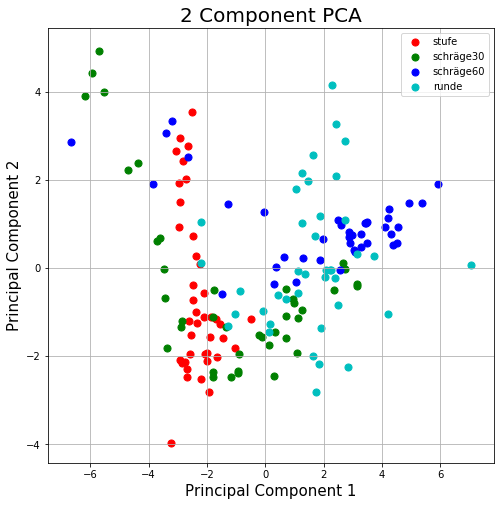

In [50]:
features = ["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
    "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
x = df.loc[:, features].values
y = df.loc[:,['target']].values
x = StandardScaler().fit_transform(x)
pd.DataFrame(data = x, columns = features).head()
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


finalDf = principalDf
finalDf['target'] = y
print(finalDf)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['stufe', 'schräge30', 'schräge60', 'runde']
colors = ['r', 'g', 'b', 'c']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

- data with mean values

In [51]:
mean_data = []
mean_data.append(np.mean(fs, axis = 1))
mean_data.append(np.mean(fs30, axis = 1))
mean_data.append(np.mean(fs60, axis = 1))
mean_data.append(np.mean(fr, axis = 1))

df = pd.DataFrame(data=mean_data, index = ["0", "30", "60", "90"], columns=["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
    "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
)
df

,Angular Second Moment,Contrast,Correlation,Sum of Squares: Variance,Inverse Difference Moment,Sum Average,Sum Variance,Sum Entropy,Entropy,Difference Veriance,Difference Entropy,Info. Measure of Correlation 1,Info. Measure of Correlation 2
0,0.000428,127.161515,0.951405,1676.991063,0.201548,240.743934,6580.802739,8.106796,12.237997,0.000290,4.287232,-0.281005,0.982032
30,0.000801,138.009938,0.949753,1412.613464,0.269147,310.452178,5512.443919,7.981898,11.681057,0.000431,3.928074,-0.335082,0.982238
60,0.004347,89.244151,0.938316,489.990668,0.406630,374.140141,1870.718522,6.817443,9.541944,0.000765,3.143974,-0.372829,0.989131
90,0.004320,29.135008,0.968702,833.446239,0.374339,256.684923,3304.649946,6.957840,9.699142,0.000796,3.047126,-0.377323,0.987822


             P1         P2
0  -2336.045926  10.765103
30 -1234.656987 -44.780798
60  2522.970087 -44.589784
90  1047.732826  78.605480


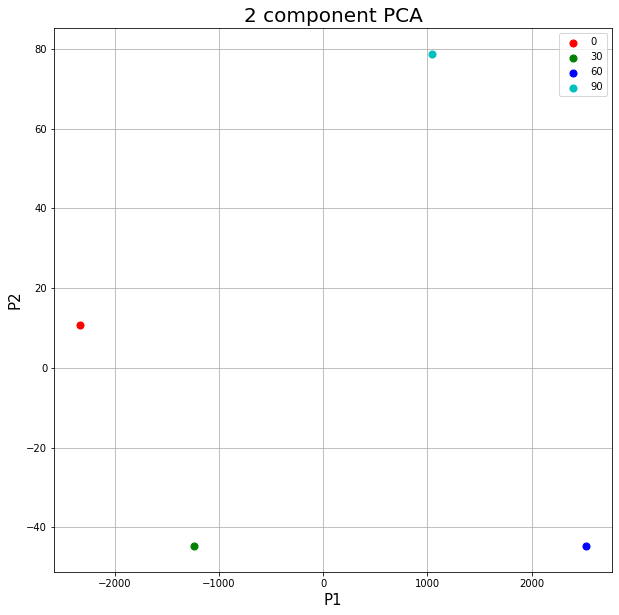

In [52]:
pca = PCA(n_components=2)
principalComponent = pca.fit_transform(df.values)
principalDf = pd.DataFrame(data = principalComponent, index = ["0", "30", "60", "90"], columns=["P1", "P2"])

print(principalDf)

fig  = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('P1', fontsize = 15)
ax.set_ylabel('P2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets =  ["0", "30", "60", "90"]
colors = ['r', 'g', 'b', 'c']
for target, color in zip(targets, colors):
    ax.scatter(principalDf.loc[target, "P1"], principalDf.loc[target, "P2"], c = color, s = 50)

ax.legend(targets)
ax.grid()